# Mitiq Tutorial

Before running this tutorial, make sure you have `mitiq` installed.

```bash
pip install mitiq
```

Use `pip list | grep mitiq` to ensure it is installed.

# Goals

- learn how to apply ZNE on a basic workflow
- apply both ZNE and DDD in conjunction


## Executors

Executors are python functions that consume a quantum circuit, and output an expectation value.
A type signature might look something like `Circuit -> float`.
That said, executors can have additional arguments used to control other parts of the execution process.
The circuit must be the first argument, however.


In [1]:
import cirq


def execute(circuit, noise_level=0.005):
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit
    with depolarizing noise."""

    # add depolarizing noise
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))

    return (
        cirq.DensityMatrixSimulator()
        .simulate(noisy_circuit)
        .final_density_matrix[0, 0]
        .real
    )

## ZNE

First, we define a simple circuit to work with.


In [2]:
a, b, c = cirq.LineQubit.range(3)

circuit = cirq.Circuit(
    cirq.H(a),
    cirq.CNOT(a, b),
    cirq.CNOT(b, c),
    cirq.S(a),
)

In [3]:
print(circuit)

0: ───H───@───S───
          │
1: ───────X───@───
              │
2: ───────────X───


### Unitary Folding

Making the circuit longer, and hence noisier.


In [4]:
from mitiq.zne.scaling import fold_gates_at_random, fold_global

folded_circuit = fold_global(circuit, scale_factor=100)

print(folded_circuit)

0: ───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@───H───H───@───S───S^-1───@──

### Extrapolation

Computing the Zero-Noise limit.


In [5]:
from mitiq.zne.inference import RichardsonFactory, LinearFactory, ExpFactory

factory = ExpFactory([1, 4, 7])

factory.run(circuit, execute)
factory.reduce()

/Users/bigsad/Downloads/qrise-2024/.venv/lib/python3.11/site-packages/mitiq/zne/inference.py:96: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  warnings.warn(
/Users/bigsad/Downloads/qrise-2024/.venv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: ExtrapolationWarning: The extrapolation fit may be ill-conditioned. Likely, more data points are necessary to fit the parameters of the model.
  warnings.warn('Covariance of the parameters could not be estimated',


0.5042144887626608

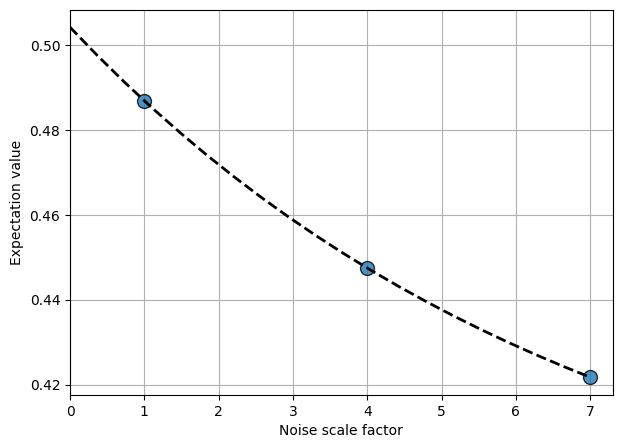

In [6]:
factory.plot_fit();

Randomized Benchmarking circuits are circuits that are in effect, equivalent to the identity. Hence, the ideal probability that the end state is $|00\cdots 0\rangle$ is 1.


In [7]:
from mitiq.benchmarks import generate_rb_circuits

circuit = generate_rb_circuits(2, num_cliffords=20)[0]

print(set(circuit.all_operations()))

{cirq.X(cirq.LineQubit(1)), (cirq.Y**-0.5).on(cirq.LineQubit(1)), cirq.CZ(cirq.LineQubit(0), cirq.LineQubit(1)), (cirq.X**0.0).on(cirq.LineQubit(0)), (cirq.X**-0.5).on(cirq.LineQubit(0)), (cirq.X**-0.5).on(cirq.LineQubit(1)), (cirq.Y**0.5).on(cirq.LineQubit(1)), (cirq.X**0.5).on(cirq.LineQubit(0)), (cirq.Y**0.0).on(cirq.LineQubit(0)), (cirq.X**0.5).on(cirq.LineQubit(1)), (cirq.X**0.0).on(cirq.LineQubit(1)), (cirq.Y**0.0).on(cirq.LineQubit(1)), (cirq.Y**0.5).on(cirq.LineQubit(0)), cirq.Y(cirq.LineQubit(0)), cirq.Y(cirq.LineQubit(1)), (cirq.Y**-0.5).on(cirq.LineQubit(0)), cirq.X(cirq.LineQubit(0))}


In [8]:
from mitiq import zne


true_value = execute(circuit, noise_level=0.0)
noisy_value = execute(circuit)
zne_value = zne.execute_with_zne(circuit, execute)

print(f"Error w/o  Mitiq: {abs((true_value - noisy_value) / true_value):.3f}")
print(f"Error w Mitiq:    {abs((true_value - zne_value) / true_value):.3f}")

Error w/o  Mitiq: 0.583
Error w Mitiq:    0.341


### Exercise

Keeping the circuit the same, can you get a smaller error by modifying some of the ZNE options?


In [12]:
from mitiq.zne.scaling import fold_global, fold_gates_at_random, insert_id_layers
from mitiq.zne.inference import (
    LinearFactory,
    RichardsonFactory,
    PolyFactory,
    ExpFactory,
)

inference_method = RichardsonFactory([1,2,3])
noise_scaling_method = insert_id_layers

zne_value = zne.execute_with_zne(
    circuit,
    execute,
    factory=inference_method,
    scale_noise=noise_scaling_method,
)

print(f"Error w/o  Mitiq: {abs((true_value - noisy_value) / true_value):.3f}")
print(f"Error w Mitiq:    {abs((true_value - zne_value) / true_value):.3f}")

Error w/o  Mitiq: 0.583
Error w Mitiq:    0.353


## DDD

We'll first need to define a circuit with lots of idle qubits. GHZ circuits are perfect for this!


In [13]:
from mitiq.benchmarks import generate_ghz_circuit

num_qubits = 6
ghz = generate_ghz_circuit(num_qubits)

print(ghz)

0: ───H───@───────────────────
          │
1: ───────X───@───────────────
              │
2: ───────────X───@───────────
                  │
3: ───────────────X───@───────
                      │
4: ───────────────────X───@───
                          │
5: ───────────────────────X───


In [14]:
from mitiq import ddd

ddd.insert_ddd_sequences(ghz, rule=ddd.rules.xx)

0: ───H───@───I───X───X───I───
          │
1: ───────X───@───I───X───X───
              │
2: ───X───X───X───@───X───X───
                  │
3: ───I───X───X───X───@───────
                      │
4: ───I───X───X───I───X───@───
                          │
5: ───I───X───I───X───I───X───

In [15]:
ddd.execute_with_ddd(ghz, execute, rule=ddd.rules.xx)

0.4451800286769867

# Stacking techniques

Mitiq is designed with the capability of stacking multiple error mitigation techniques. Let's try to combine DDD and ZNE.


In [16]:
from mitiq.zne.scaling import fold_global, fold_gates_at_random, insert_id_layers


@ddd.ddd_decorator(rule=ddd.rules.xyxy)
@zne.zne_decorator(factory=RichardsonFactory([1, 3, 7]), scale_noise=insert_id_layers)
def new_execute(circuit):
    return execute(circuit)

In [17]:
new_execute(circuit)

0.5344274155795572

In [ ]:
circuit

0: ───X^0────────────@───Y^0.5────@───Y^0.5────Y^-0.5───X^0───@───Y^0.5────X^0.5────Y^-0.5───X^0.5─────────@───X^0──────Y^-0.5───X^0.5─────────@───Y^0.5───X^0.5───Y^-0.5───X^0.5───Y^-0.5───@───X^-0.5───Y^-0.5───Y^-0.5───X^0.5───@───Y^0.5────@───Y^0.5────X^-0.5───Y^-0.5───@───X^0───X^-0.5───Y^0────────────@───X^0─────Y───────X^0.5───@───Y^0.5───X^0.5───X^0──────────────@───Y^-0.5───@───Y^0.5────@───Y───────X^-0.5───────────@───Y^0.5────@───Y────────X^0.5───Y^0.5───X^0───@───Y^0.5───X^0.5────X────────Y^0.5───@───X^-0.5───Y^-0.5───Y^-0.5───X^0.5───Y^-0.5───@───Y^0.5────@───X^-0.5───Y^-0.5───X^0.5───X^-0.5───Y^0─────@───X^-0.5───Y^-0.5───Y^0.5───X^0.5───Y^0.5───@───Y^0.5────@───X^-0.5───Y^-0.5───X^0.5───Y^-0.5───X^0.5───Y^-0.5───X^0───@───Y^0.5────@───Y───────X^0.5────X─────Y^0───@───X^0───Y^0.5───X^0.5───Y^0.5────@───X^0─────Y────────X^0──────────────@───Y^0.5────@───X^-0.5───Y^-0.5───X^0.5───
                     │            │                           │                                            │                                   │                                             │                                      │            │                              │                                 │                           │                                    │            │            │                            │            │                                  │                                     │                                               │            │                                              │                                             │            │                                                             │            │                                │                                  │                                     │            │
1: ───X─────Y^-0.5───@───X^-0.5───@───Y^-0.5───X^-0.5───Y^0───@───X^-0.5───Y^-0.5───X^0.5────Y^0.5───X^0───@───X^-0.5───Y^-0.5───X^0.5───X^0───@───Y^0.5───X^0.5───Y^0.5─────────────────────@───Y────────X^0.5────X^0.5────Y^0.5───@───X^-0.5───@───Y^-0.5───Y────────X────────@───Y─────X^0.5────X─────Y^-0.5───@───Y^0.5───Y^0.5───X^0.5───@───Y───────X^0.5───X^0.5───Y^-0.5───@───Y^0.5────@───Y^-0.5───@───Y^0.5───X^-0.5───Y^0.5───@───X^-0.5───@───Y^-0.5───X^0.5───Y^0.5─────────@───Y^0.5───X^-0.5───Y^-0.5───────────@───Y────────X^0.5────X────────Y^0.5────────────@───X^-0.5───@───X^0.5────Y^0.5────X^0.5───Y^-0.5───X^0.5───@───Y^0.5────X^0──────────────────────────────@───X^-0.5───@───X^0.5────Y────────X^0─────X^0.5────Y^0.5──────────────────@───X^-0.5───@───X^0.5───X^-0.5───Y^0─────────@───Y─────X^0.5───X───────Y^-0.5───@───Y^0.5───Y^-0.5───X^0.5───Y^-0.5───@───X^-0.5───@───X^0.5────Y^0.5────X^0.5───